In [267]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt

In [268]:
input_file = "input.py"

with open(input_file) as f:
    text = f.read()

print(text)

import json as jorre

y = 9.77
x = [37, 2]
for k in range(x[0]):
    print((("öh" * k)))

this_variable = "hej på dig"

a_longer123string = this_variable + "ööhö"


In [269]:
def tokenize(text) -> list[str]:
    """Tokenize a text"""
    # Possible string delimiters
    string_delims = {'"', "'", '"""', "'''"}

    # split everything
    tokens: list[str] = re.findall(r"(\w+|[^\w\s]+|\s+|\n)", text)

    print(tokens)
    ## split tokens without letters or numbers
    tmp: list[str] = []
    for t in tokens:
        if bool(re.search(r"\p{L}|\p{digit}", t)):
            tmp.append(t)
        # elif len(t) > 1 and all((c == t[0] for c in t)):
        #     tmp.append(t)
        else:
            tmp.extend(list(t))

    tokens = tmp

    ## reunite string literals
    tmp = []
    tags = []
    current_delim = ""
    current_string = ""
    for i, t in enumerate(tokens):
        if current_delim == "":
            if t in string_delims:
                # start a string
                current_delim = t
                current_string += t
            else:
                tmp.append(t)
                tags.append("unk")
        else:
            if t == current_delim:
                # break current string
                current_delim = ""
                current_string += t
                tmp.append(current_string)
                tags.append("str")
                current_string = ""
            else:
                # add to current string
                current_string += t

    tokens = tmp

    ## reunite decimal numbers
    tmp = []
    tmp_tags = []
    current_num = ""
    for i, (token, tag) in enumerate(zip(tokens, tags)):
        token_next = None
        if i < len(tokens) - 1:
            token_next = tokens[i + 1]

        num_char = token.isdigit() or (token == "." and token_next.isdigit())

        if current_num == "":
            if num_char:
                current_num = token
            else:
                tmp.append(token)
                tmp_tags.append(tag)
        else:
            if num_char:
                current_num += token
            else:
                # end number
                tmp.append(current_num)
                tmp_tags.append("num")
                current_num = ""
                tmp.append(token)
                tmp_tags.append(tag)

    tokens = tmp
    tags = tmp_tags

    return tokens, tags


tokens, tags = tokenize(text)
print(tokens)

['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n\n', 'y', ' ', '=', ' ', '9', '.', '77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']):', '\n    ', 'print', '((("', 'öh', '"', ' ', '*', ' ', 'k', ')))', '\n\n', 'this_variable', ' ', '=', ' ', '"', 'hej', ' ', 'på', ' ', 'dig', '"', '\n\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"', 'ööhö', '"']
['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n', '\n', 'y', ' ', '=', ' ', '9.77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']', ')', ':', '\n', ' ', ' ', ' ', ' ', 'print', '(', '(', '(', '"öh"', ' ', '*', ' ', 'k', ')', ')', ')', '\n', '\n', 'this_variable', ' ', '=', ' ', '"hej på dig"', '\n', '\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"ööhö"']


In [270]:
a = [1, 2, 3]

## tagging

In [271]:
print("# tokens", len(tokens))

known_chars = {
    "op": r"=!%&/+-*:,",
    "brac_op": r"([{",
    "brac_cl": r")]}",
    "keyword": r"for|while|as|in|if|else",
}

# first: tag individual tokens

for i, token in enumerate(tokens):
    if token.isdigit():
        tags[i] = "num"
        continue
    elif not bool(re.search("[^\s]", token)):
        tags[i] = "wsp"

    for key in known_chars.keys():
        if token in known_chars[key]:
            tags[i] = key
            break


# print
for i, x in enumerate(zip(tags, tokens)):
    if x[0] != "unk" and x[0] != "wsp":
        print(i, x[0], repr(x[1]))

# tokens 75
4 keyword 'as'
11 op '='
13 num '9.77'
17 op '='
19 brac_op '['
20 num '37'
21 op ','
23 num '2'
24 brac_cl ']'
26 keyword 'for'
30 keyword 'in'
33 brac_op '('
35 brac_op '['
36 num '0'
37 brac_cl ']'
38 brac_cl ')'
39 op ':'
46 brac_op '('
47 brac_op '('
48 brac_op '('
49 str '"öh"'
51 op '*'
54 brac_cl ')'
55 brac_cl ')'
56 brac_cl ')'
61 op '='
63 str '"hej på dig"'
68 op '='
72 op '+'
74 str '"ööhö"'


In [272]:
for x in zip(tags, tokens):
    if x[0] == "unk":
        print("\t".join(x))

for x in zip(tags, tokens):
    if x[0] == "wsp":
        print(repr(x[1]), end=";")

unk	import
unk	json
unk	jorre
unk	y
unk	x
unk	k
unk	range
unk	x
unk	print
unk	k
unk	this_variable
unk	a_longer123string
unk	this_variable
' ';' ';' ';'\n';'\n';' ';' ';'\n';' ';' ';' ';'\n';' ';' ';' ';'\n';' ';' ';' ';' ';' ';' ';'\n';'\n';' ';' ';'\n';'\n';' ';' ';' ';' ';

## features

In [273]:
feature_names = (
    "in_()",
    "in_[],",
    "before_.",
    "after_.",
    "before_(",
    "before_[",
    "before_op",
    "after_op",
)

### bracket level

In [274]:
brac_level = []
current_level = 0
for i, token in enumerate(tokens):
    tag = tags[i]
    if tag == "brac_op":
        brac_level.append(current_level)
        current_level += 1
        tags[i] = f"brac{current_level}"
    elif tag == "brac_cl":
        tags[i] = f"brac{current_level}"
        current_level -= 1
        brac_level.append(current_level)
    else:
        brac_level.append(current_level)

feature matrix (75, 8)
(0, 'in_()') (1, 'in_[],') (2, 'before_.') (3, 'after_.') (4, 'before_(') (5, 'before_[') (6, 'before_op') (7, 'after_op')


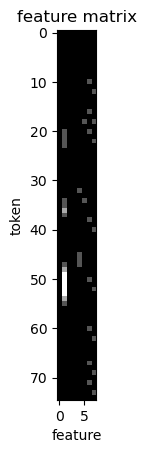

In [275]:
features = np.zeros((len(tokens), len(feature_names)))

print("feature matrix", features.shape)
print(*zip(range(len(feature_names)), feature_names))

# in brackets?
features[:, 1] = np.array(brac_level)

# before and after?
for i, token in enumerate(tokens):
    if token == ".":
        if i > 0:
            features[i - 1, 2] = 1
        if i < len(tokens) - 1:
            features[i + 1, 3] = 1

    if token == "(":
        if i > 0:
            features[i - 1, 4] = 1

    if token == "[":
        if i > 0:
            features[i - 1, 5] = 1

    if tags[i] == "op":
        if i > 0:
            features[i - 1, 6] = 1
        if i < len(tokens) - 1:
            features[i + 1, 7] = 1


plt.figure()
plt.imshow(features, cmap="gray")
plt.title("feature matrix")
plt.xlabel("feature")
plt.ylabel("token")
plt.show()

## classify

(75, 2)


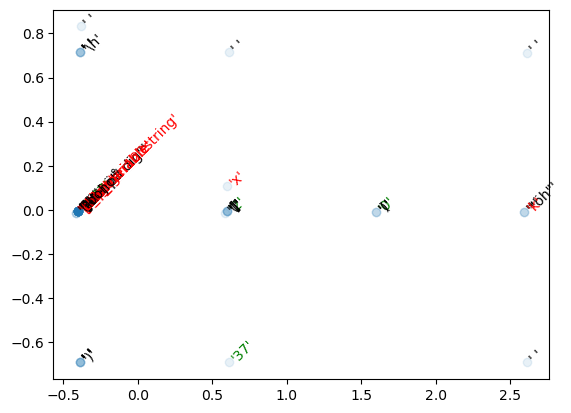

In [276]:
from sklearn.decomposition import PCA

rng = np.random.default_rng()

pca = PCA(n_components=2)

f_PCA = pca.fit_transform(features)
print(f_PCA.shape)

plt.figure()
plt.scatter(x=f_PCA[:, 0], y=f_PCA[:, 1], alpha=0.1)
for i, t in enumerate(tokens):
    c = "#000"
    if tags[i] == "unk":
        c = "r"
    elif tags[i] == "num":
        c = "g"

    plt.text(x=f_PCA[i, 0], y=f_PCA[i, 1], s=repr(t), rotation=45, color=c)

In [277]:
classes = tuple(sorted(set(tags)))
print(classes)

('brac1', 'brac2', 'brac3', 'keyword', 'num', 'op', 'str', 'unk', 'wsp')


## cleanup

In [278]:
print("# tokens/tags", len(tokens))

# Merge adjacent of same class
tmp = []
tmp_tags = []

current_seq = []
for i, (token, tag) in enumerate(zip(tokens, tags)):
    tag_next = tags[i + 1] if i < len(tags) - 1 else None
    if not tag == tag_next:
        if len(current_seq) > 0:
            current_seq.append(token)
            tmp.append("".join(current_seq))
            tmp_tags.append(tag)
            current_seq = []
        else:
            tmp.append(token)
            tmp_tags.append(tag)
    else:
        current_seq.append(token)

tokens = tmp
tags = tmp_tags

print("after merge # tokens/tags", len(tokens))
print("count unknown", sum([t == "unk" for t in tags]))

# tokens/tags 75
after merge # tokens/tags 68
count unknown 13


In [279]:
print(tokens)

['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n\n', 'y', ' ', '=', ' ', '9.77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']', ')', ':', '\n    ', 'print', '(', '(', '(', '"öh"', ' ', '*', ' ', 'k', ')', ')', ')', '\n\n', 'this_variable', ' ', '=', ' ', '"hej på dig"', '\n\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"ööhö"']


In [280]:
def html_specials(text: str) -> str:
    """Replace html reserved characters, preserve indentation and line-breaks"""
    text = re.sub(r"&", r"&amp;", text)
    text = re.sub(r"<", r"&lt;", text)
    text = re.sub(r">", r"&gt;", text)
    text = re.sub(r'"', r"&quot;", text)
    text = re.sub(r"'", r"&apos;", text)
    text = re.sub(r"  ", r"&nbsp; ", text)
    text = re.sub(r"\n", r"<br>\n", text)
    return text


EXCLUDE_TAGS = ("unk", "wsp")

tokens_with_tags = []
for token, tag in zip(tokens, tags):
    # fix html specials
    token_text = html_specials(token)
    if tag in EXCLUDE_TAGS:
        tokens_with_tags.append(token_text)
    else:
        tokens_with_tags.append(f"""<span class="{tag}">{token_text}</span>""")

text = "".join(tokens_with_tags)


print(text)


import json <span class="keyword">as</span> jorre<br>
<br>
y <span class="op">=</span> <span class="num">9.77</span><br>
x <span class="op">=</span> <span class="brac1">[</span><span class="num">37</span><span class="op">,</span> <span class="num">2</span><span class="brac1">]</span><br>
<span class="keyword">for</span> k <span class="keyword">in</span> range<span class="brac1">(</span>x<span class="brac2">[</span><span class="num">0</span><span class="brac2">]</span><span class="brac1">)</span><span class="op">:</span><br>
&nbsp; &nbsp; print<span class="brac1">(</span><span class="brac2">(</span><span class="brac3">(</span><span class="str">&quot;öh&quot;</span> <span class="op">*</span> k<span class="brac3">)</span><span class="brac2">)</span><span class="brac1">)</span><br>
<br>
this_variable <span class="op">=</span> <span class="str">&quot;hej på dig&quot;</span><br>
<br>
a_longer123string <span class="op">=</span> this_variable <span class="op">+</span> <span class="str">&quot;ö

## output

In [281]:
css_link = '<link rel="stylesheet" type="text/css" href="_highlight_style.css">'
html_text = f"""<div class="code-snippet">{text}</div>"""
final_html = f"""
<head>
    {css_link}
</head>
<body>
    {html_text}
</body>
"""

with open("output.html", "w") as f:
    f.write(final_html)